# Preliminary K-Means Clustering Scripts

Author: Brandon Fan

Last Edit Date: 12/28/17

In [1]:
%matplotlib inline

In [2]:
import sys
from importlib import reload
sys.path.insert(0, '../server')
from similarity_functions import Similarity

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandonfan1256/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brandonfan1256/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
from jupyterthemes import jtplot
jtplot.style()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

## Load Data & Construct Corpus

In [4]:
# declare constants
BIBLE_FILE = '../server/files/english-web-bible.json'
GLOVE_FILE = '../server/files/glove.6B.200d.txt'

In [5]:
# create glove vectors
SIMILARITY = Similarity(BIBLE_FILE, GLOVE_FILE, initialize=False)
SIMILARITY.initialize(create_matrix=False)

 - Loading GloVe File...
 - Tokenizing Data...
 - Converting GloVe Vectors...


In [7]:
# get data from similarity initialization, 
# go to server/similarity_functions/similarity.py for more info
verse_data = SIMILARITY.verse_data
vectorized_corpus = np.array([verse['vector'] for verse in verse_data])
del SIMILARITY

## Implement Clustering

In [30]:
CLUSTERS = 3 # hyperparameter to change and test

### Mini-Batch K-Means Model

In [31]:
# initialize mini-batch kmeans model
mbk_clf = MiniBatchKMeans(n_clusters=CLUSTERS)

In [32]:
%%time
mbk_predictions = mbk_clf.fit_predict(vectorized_corpus) # fit and predict cluster values

CPU times: user 1.57 s, sys: 1.18 s, total: 2.75 s
Wall time: 3.72 s


In [33]:
# add predictions to verse_data
for index, prediction in enumerate(mbk_predictions):
    verse_data[index]['mbk_cluster'] = prediction

### K-Means Model

In [34]:
clf = KMeans(n_clusters=CLUSTERS)

In [35]:
%%time
predictions = clf.fit_predict(vectorized_corpus) # fit and predict cluster values

CPU times: user 2min 34s, sys: 16.5 s, total: 2min 51s
Wall time: 2min 46s


In [36]:
# add predictions to verse_data
for index, prediction in enumerate(predictions):
    verse_data[index]['cluster'] = prediction

## Plot Results

In [37]:
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

k_means_cluster_centers = np.sort(clf.cluster_centers_, axis=0) # get cluster centers
mbk_means_cluster_centers = np.sort(mbk_clf.cluster_centers_, axis=0) # get cluster centers
k_means_labels = pairwise_distances_argmin(vectorized_corpus, k_means_cluster_centers) # find labels for data
mbk_means_labels = pairwise_distances_argmin(vectorized_corpus, mbk_means_cluster_centers) # find labels for data
order = pairwise_distances_argmin(k_means_cluster_centers,
                                  mbk_means_cluster_centers) 

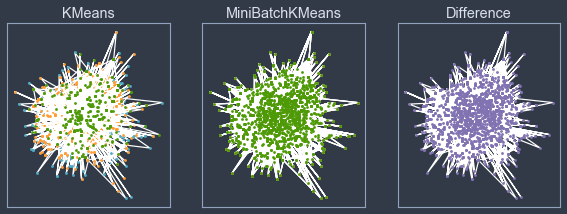

In [40]:
fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(CLUSTERS), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(vectorized_corpus[my_members, 0], vectorized_corpus[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(CLUSTERS), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(vectorized_corpus[my_members, 0], vectorized_corpus[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(CLUSTERS):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

identic = np.logical_not(different)
ax.plot(vectorized_corpus[identic, 0], vectorized_corpus[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(vectorized_corpus[different, 0], vectorized_corpus[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()